# Incrementally Calculate Means and Bootstrap Instances

Configured for remote Jupyter access on Graham

***

In [1]:
import glob
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

%matplotlib inline

In [2]:
#mesh = xr.open_dataset('~/MEOPAR/grid/mesh_mask201702.nc')
mesh = xr.open_dataset('~/MEOPAR/grid/mesh_mask201702.nc')
tmask = 1- mesh.tmask[0, 0]

In [3]:
directory = ('/home/allen/projects/def-allen/MIDOSS/monte-carlo-results/' 
                             +'north_strait_5th362_2021-06-14T150753/')
testfile_a = xr.open_dataset(directory
                             + 'results/north_strait_5th362-0/'
                             +'Lagrangian_diesel-0_north_strait_5th362-0.nc')

In [5]:
testfile_a

<xarray.Dataset>
Dimensions:                  (grid_x: 396, grid_x_latlon: 397, grid_y: 896, grid_y_latlon: 897, grid_z: 40, time: 168)
Coordinates:
  * time                     (time) datetime64[ns] 2018-04-12T00:30:00 ... 20...
  * grid_y                   (grid_y) int16 0 1 2 3 4 5 ... 891 892 893 894 895
  * grid_x                   (grid_x) int16 0 1 2 3 4 5 ... 391 392 393 394 395
  * grid_z                   (grid_z) int16 0 1 2 3 4 5 6 ... 34 35 36 37 38 39
  * grid_y_latlon            (grid_y_latlon) float32 0.0 1.0 2.0 ... 895.0 896.0
  * grid_x_latlon            (grid_x_latlon) float32 0.0 1.0 2.0 ... 395.0 396.0
Data variables:
    OilConcentration_2D      (time, grid_y, grid_x) float64 ...
    Thickness_2D             (time, grid_y, grid_x) float64 ...
    Dissolution_3D           (time, grid_z, grid_y, grid_x) float64 ...
    OilConcentration_3D      (time, grid_z, grid_y, grid_x) float64 ...
    OilWaterColumnOilVol_3D  (time, grid_z, grid_y, grid_x) float64 ...
    Latitude                 (grid_y_latlon, grid_x_latlon) float64 ...
    Longitude                (grid_y_latlon, grid_x_latlon) float64 ...
    Beaching_Time            (grid_y, grid_x) datetime64[ns] ...
    Beaching_Volume          (grid_y, grid_x) float64 ...
    Oil_Arrival_Time         (grid_y, grid_x) datetime64[ns] ...
Attributes:
    nco_openmp_thread_number:   1
    history:                    Mon Jun 14 17:46:44 2021: ncks -4 -L4 -A /loc...
    NCO:                        4.6.6
    history_of_appended_files:  Mon Jun 14 17:46:44 2021: Appended file /loca...

## Can we use Oil Arrival Time

In [4]:
testfile_a.Oil_Arrival_Time[:,:].max()

<xarray.DataArray 'Oil_Arrival_Time' ()>
array('2018-04-18T23:30:00.000000000', dtype='datetime64[ns]')

In [9]:
oiltime = (np.array(testfile_a.Oil_Arrival_Time - testfile_a.Oil_Arrival_Time.min())
              ) /  np.timedelta64(1, 's') /3600./24.

In [22]:
oiled = np.ma.masked_array(oiltime, oiltime == 0)


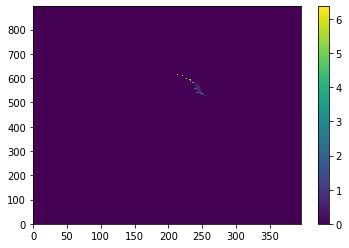

In [14]:
colours = plt.pcolormesh(oiltime)
plt.colorbar();

(200.0, 320.0)

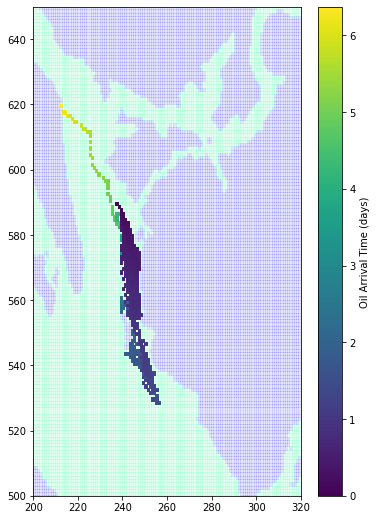

In [33]:
fig, ax = plt.subplots(1, 1, figsize=(6, 9))

ax.pcolormesh(tmask, cmap='winter_r', alpha=0.1)

C = ax.pcolormesh(
     oiled,
    zorder=2, vmin=0,
)
cb = fig.colorbar(C, ax=ax);
cb.set_label('Oil Arrival Time (days)')
ax.set_ylim(500, 650)
ax.set_xlim(200, 320)

In [27]:
beachtime = (np.array(testfile_a.Beaching_Time - testfile_a.Beaching_Time.min())
              ) /  np.timedelta64(1, 's') /3600./24.

In [28]:
beached = np.ma.masked_array(beachtime, beachtime == 0)


(200.0, 320.0)

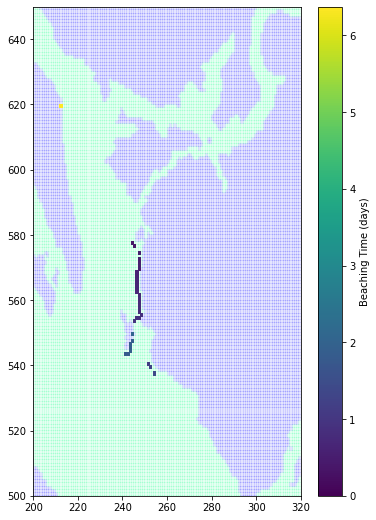

In [34]:
fig, ax = plt.subplots(1, 1, figsize=(6, 9))

ax.pcolormesh(tmask, cmap='winter_r', alpha=0.1)

C = ax.pcolormesh(
     beached,
    zorder=2, vmin=0,
)
cb = fig.colorbar(C, ax=ax);
cb.set_label('Beaching Time (days)')
ax.set_ylim(500, 650)
ax.set_xlim(200, 320)

### Yes oil arrival time looks good.

***

# Beaching Time

In [19]:
minoil = 25 # litres per grid cell

In [35]:
#set up bootstrap

In [35]:
mcsize = 49
beaching_time = np.zeros((mcsize+1, 896, 396))
rng = np.random.default_rng()

In [36]:
pois = rng.poisson(1, mcsize)
pois

array([0, 1, 2, 3, 2, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 2, 1, 0, 3, 2, 0, 2,
       2, 0, 1, 0, 0, 3, 2, 0, 1, 0, 0, 0, 1, 0, 0, 3, 0, 0, 1, 0, 2, 1,
       0, 3, 2, 0, 3])

In [37]:
beaching_time = np.zeros((mcsize+1, 896, 396))
beachcount = np.zeros((896, 396))
for filename in glob.glob(directory+'results/*/Lagrangian*.nc'):
    with xr.open_dataset(filename) as data:
        pois = rng.poisson(1, mcsize)
        beachtime = (np.array(data.Beaching_Time - data.Beaching_Time.min())
              ) /  np.timedelta64(1, 's') /3600./24.
        beached = (beachtime == 0) | (data.Beaching_Volume < minoil/1000.)
        beaching_time[0] =  beached * beaching_time[0] + (1 - beached) * (
            beaching_time[0] * beachcount + beachtime) / (beachcount + 1)
        for ii in range(1, mcsize):
            beaching_time[ii] = beached * beaching_time[ii] + (1 - beached) * (
                beaching_time[ii] * beachcount + beachtime * pois[ii-1]) / (beachcount + 1)
        beachcount = beachcount + (beachtime !=0)
#        print(beachcount[520, 273], beached[520, 273], beaching_time[0:, 520, 273])

In [42]:
# Good if good to half a day or 15% of beaching time
absol = 0.5
perol = 0.15

In [44]:
ma_beaching_time = np.ma.masked_array(beaching_time[0], beaching_time[0] == 0)
beached_ste = np.std(beaching_time, axis=0, ddof=1) / np.sqrt(mcsize)
beached = np.ma.masked_array(beaching_time[0], (beaching_time[0] == 0) | (
    (beached_ste > absol) & (beached_ste > perol*beaching_time[0]))) 

In [45]:
ma_beaching_time.count()

2116

In [46]:
beached.count()

2039

1.3220805582683002
0.18886865118118573
1.8680555555555556


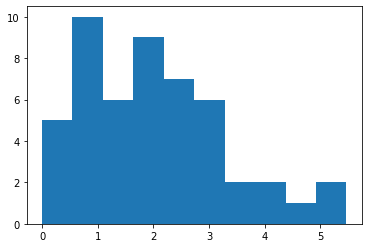

In [47]:
plt.hist(beaching_time[0:, 520, 273])
print (np.std(beaching_time[:, 520, 273], axis=0, ddof=1))
print (beached_ste[520, 273])
print (beaching_time[0, 520, 273])

In [48]:
ma_beached_ste = np.ma.masked_array(beached_ste, beached_ste == 0)

1.8680555555555556 0.18886865118118573


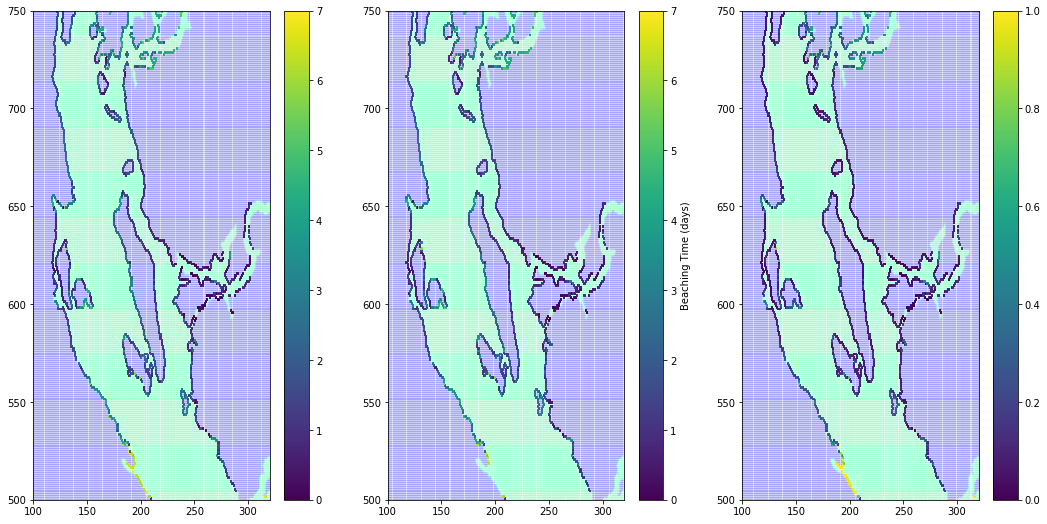

In [49]:
fig, axs = plt.subplots(1, 3, figsize=(18, 9))

for ax in axs:
    ax.pcolormesh(tmask[1:, 1:], cmap='winter_r', alpha=0.1)
    ax.set_ylim(500, 750)
    ax.set_xlim(100, 320)

C = axs[0].pcolormesh(
     ma_beaching_time,
    zorder=2, vmin=0, vmax=7
)
cb = fig.colorbar(C, ax=axs[0]);    
    
C = axs[1].pcolormesh(
     beached,
    zorder=2, vmin=0, vmax=7
)
cb = fig.colorbar(C, ax=axs[1]);
cb.set_label('Beaching Time (days)')

C = axs[2].pcolormesh(
     ma_beached_ste,
    zorder=2, vmin=0, vmax=1
)
cb = fig.colorbar(C, ax=axs[2]);

print (beached[520, 273], ma_beached_ste[520, 273])

More gaps when I use 25 litres as well as stderr < 15% of signal or < 0.5 days but still pretty good signal throughout the region where we actually have spills

# Beaching Presence

In [27]:
beaching_presence = np.zeros((mcsize+1, 896, 396))
beachPrescount = 0
for filename in glob.glob(directory+'results/*/Lagrangian*.nc'):
    with xr.open_dataset(filename) as data:
        pois = rng.poisson(1, mcsize)
        beached = data.Beaching_Volume > minoil/1000.
        beaching_presence[0] =  (beaching_presence[0] * beachPrescount + beached) / (beachPrescount + 1)
        for ii in range(1, mcsize):
            beaching_presence[ii] = (beaching_presence[ii] * beachPrescount + beached * pois[ii-1]) / (beachPrescount + 1)
        beachPrescount = beachPrescount + 1

In [53]:
absol = 1e-3
perol = 0.15
ma_beaching_pres = np.ma.masked_array(beaching_presence[0], beaching_presence[0] == 0)
beachPres_ste = np.std(beaching_presence, axis=0, ddof=1) / np.sqrt(mcsize)
beachPok = np.ma.masked_array(beaching_presence[0], (beaching_presence[0] == 0) | (
    (beachPres_ste > absol) & (beachPres_ste > perol*beaching_presence[0]))) 

In [54]:
ma_beachPres_ste = np.ma.masked_array(beachPres_ste, beachPres_ste == 0)

0.008310249307479228 0.0006596824325021688


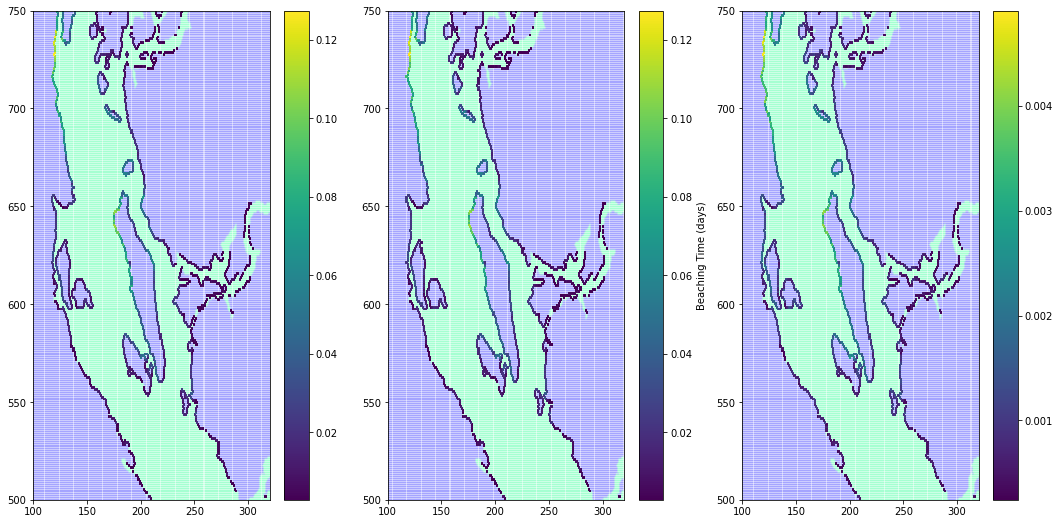

In [56]:
fig, axs = plt.subplots(1, 3, figsize=(18, 9))

for ax in axs:
    ax.pcolormesh(tmask[1:, 1:], cmap='winter_r', alpha=0.1)
    ax.set_ylim(500, 750)
    ax.set_xlim(100, 320)

C = axs[0].pcolormesh(
     ma_beaching_pres,
    zorder=2, #vmin=0, vmax=7
)
cb = fig.colorbar(C, ax=axs[0]);    
    
C = axs[1].pcolormesh(
     beachPok,
    zorder=2, #vmin=0, vmax=7
)
cb = fig.colorbar(C, ax=axs[1]);
cb.set_label('Beaching Time (days)')

C = axs[2].pcolormesh(
     ma_beachPres_ste,
    zorder=2, #vmin=0, vmax=1
)
cb = fig.colorbar(C, ax=axs[2]);

print (beaching_presence[0, 520, 273], ma_beachPres_ste[520, 273])